# Jet Energy Reolution for separately central jet and forward jet

Notes: 

1. Calculates the distance(in terms of deltaR) between each jet and gen jet in terms of eta and phi
2. Finds the closest gen jet to each jet based on the calculated distance
3. Add an upper cut(deltaR is below 0.4) to avoid issues just to avoid fat tails in the resolution
4. Calculates the ratio of Jet.PT to GenJet.PT for each pair of jet and gen jet for each of the event
5. For RMSE, define some pT binning, group the jets according to that, calculate the RMSE of the ratio separately for each bin using jets belonging to that bin
6. Draw 2D plot between PT_Jet and RMSE(ratio)

#### These numbers which we will get need to be compared to resolution numbers appearing in ATLAS jet/MET paper https://arxiv.org/pdf/2007.02645.pdf
#### and based on that we should decide if we tweak the delphes parameters up or down (and make another sample).
#### See Fig.26a, 29a and 30 and need to just make sure the compatibility with ATLAS is reasonable in regions where we have most of our jets

--> Jet.PT is using instead of Jet.Energy

In [175]:
import ROOT
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

ROOT.gSystem.Load("libDelphes")

try:
    ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
    ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')
except:
    pass

def energy_resolution(root_file_path, min_ratio, max_ratio):
    # Create chain of root trees
    chain = ROOT.TChain("Delphes")
    chain.Add(root_file_path)

    # Create object of class ExRootTreeReader
    treeReader = ROOT.ExRootTreeReader(chain)
    numberOfEntries = treeReader.GetEntries()

    # Get pointers to the branches containing Jet and GenJet information
    branchJet = treeReader.UseBranch("Jet")
    branchGenJet = treeReader.UseBranch("GenJet")

    # Lists to store GenJet PT and corresponding ratios for central jets and forward jets
    gen_jet_pts = []
    central_ratios = []

    pt_bins = np.logspace(math.log(30)/math.log(10), math.log(900)/math.log(10), 30)  # 50 bins from 0 to 1301 GeV

    # Lists to store RMSE for each pT bin
    central_ratios_rmse_bins = []

    # Loop over all events
    for entry in range(numberOfEntries):
        # Load selected branches with data from specified event
        treeReader.ReadEntry(entry)
        
        num_jets = branchJet.GetEntries()
        num_gen_jets = branchGenJet.GetEntries()
        
        # Loop over each gen jet and find the closest reco jet
        for i in range(num_gen_jets):
            gen_jet = branchGenJet.At(i)
            
            # Find the closest reco jet to the gen jet in terms of deltaR
            closest_jet = None
            min_delta_r = 999999.0
            
            for j in range(num_jets):
                jet = branchJet.At(j)
                
                delta_eta = jet.Eta - gen_jet.Eta
                delta_phi = ROOT.TVector2.Phi_mpi_pi(jet.Phi - gen_jet.Phi)
                delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
                if delta_r < 0.4:
                    if delta_r < min_delta_r:
                        min_delta_r = delta_r
                        closest_jet = jet
                    
            # Calculate the ratio of RecoJet.PT to GenJet.PT
            if closest_jet and 0.2 <= abs(gen_jet.Eta) < 0.7:  # Selecting gen jets in the specified eta range
                jet_pt_ratio = closest_jet.PT / gen_jet.PT
                if min_ratio <= jet_pt_ratio <= max_ratio:  # Consider ratios within a reasonable range
                    gen_jet_pts.append(gen_jet.PT)
                    central_ratios.append(jet_pt_ratio)

    # Convert lists to numpy arrays for plotting
    gen_jet_pts = np.array(gen_jet_pts)
    central_ratios = np.array(central_ratios)

    # Loop over each pT bin for RMSE calculation separately for each bin using jets belonging to that bin
    for i in range(len(pt_bins) - 1):
        # Select gen jets within the current pT bin
        central_ratios_bin = central_ratios[(gen_jet_pts >= pt_bins[i]) & (gen_jet_pts < pt_bins[i + 1])]
        
        # Calculate RMSE for central jets
        if len(central_ratios_bin) > 0:
            central_ratios_rmse_bin = np.nanstd(central_ratios_bin) # Use np.nanstd to ignore NaN values
            central_ratios_rmse_bins.append(central_ratios_rmse_bin)
        else: # Handle the case where there are no elements in the slice
            central_ratios_rmse_bins.append(np.nan)  # or any other value to signify no data

    # Remove NaN values from the data
    valid_indices = ~np.isnan(central_ratios_rmse_bins)
    pt_bins_valid = pt_bins[:-1][valid_indices]
    central_ratios_rmse_bins_valid = np.array(central_ratios_rmse_bins)[valid_indices]

    def fitting_function(pt, N, S, C):
        #print(pt,N,S,C)
        return np.sqrt((N / pt) **2 + (S / np.sqrt(pt)) ** 2 + C **2)

    # Fit the function to the data
    popt, pcov = curve_fit(fitting_function, pt_bins_valid, central_ratios_rmse_bins_valid)

    # RMSE of GenJet PT to RecoJet PT ratios
    plt.figure(figsize=(10, 5))

    plt.scatter(pt_bins[:-1], central_ratios_rmse_bins, s=100, c='blue', alpha=0.7, label='Jets') #  represents solid circle
    plt.plot(pt_bins_valid, fitting_function(pt_bins_valid, *popt), color='red', linestyle='-', label='Fit')
    plt.xlabel(r'$\mathbf{P_T^{jet} [GeV]}$', fontsize=14, position=(1, 0))
    plt.ylabel(r'$\mathbf{Jet\ Energy\ Resolution}$', fontsize=14, position=(0, 1))
    plt.title(' ')
    #plt.grid(True)
    plt.xscale('log')

    # Add annotations
   
    plt.text(260, 0.31, r'$\mathbf{Anti-k_t~R = 0.4}$', fontsize=14)
    plt.text(268, 0.29, r'$\mathbf{0.2 \leq |\eta| < 0.7}$', fontsize=14)
    plt.text(254, 0.27, ' ● ', fontsize=13, color='blue')
    plt.text(295, 0.27, ' $\mathbf{Jets}$ ', fontsize=14)
    plt.text(250, 0.25, ' $\mathbf{-}$ ', fontsize=16, color='red')
    plt.text(300, 0.25, r'$\mathbf{N / P_T \oplus S/\sqrt{P_T} \oplus C}$', fontsize=14)

    plt.show()


    # Print the estimated values of N, S, and C
    print("Estimated Parameters:")
    print("N:", popt[0])
    print("S:", popt[1])
    print("C:", popt[2])



# merge all 100k events

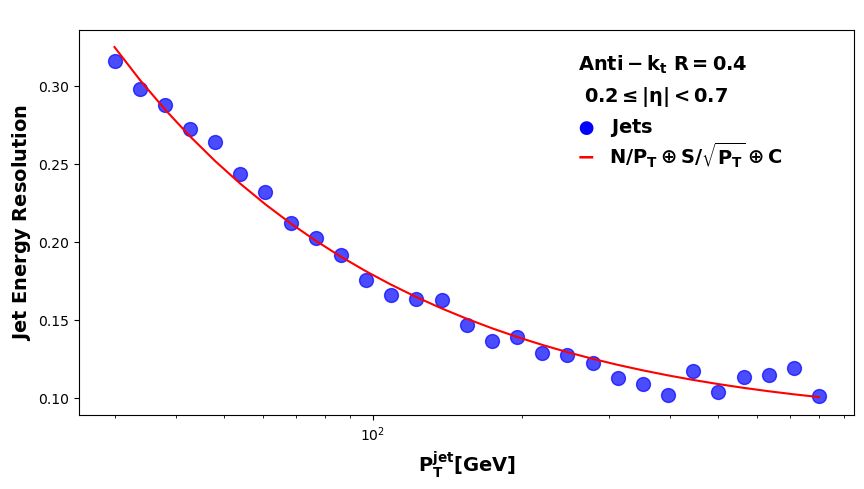

Estimated Parameters:
N: 4.513964754313183
S: -1.5051015851791847
C: 0.0851977755990461


In [176]:
energy_resolution("/data/analysis/rhammad/merged_all_100k_pileUp.root", -100000, 1000000)

# try to plot with error bars but those are very small

In [172]:
import ROOT
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

ROOT.gSystem.Load("libDelphes")

try:
    ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
    ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')
except:
    pass

def energy_resolution_bars(root_file_path, min_ratio, max_ratio):
    # Create chain of root trees
    chain = ROOT.TChain("Delphes")
    chain.Add(root_file_path)

    # Create object of class ExRootTreeReader
    treeReader = ROOT.ExRootTreeReader(chain)
    numberOfEntries = treeReader.GetEntries()

    # Get pointers to the branches containing Jet and GenJet information
    branchJet = treeReader.UseBranch("Jet")
    branchGenJet = treeReader.UseBranch("GenJet")

    # Lists to store GenJet PT and corresponding ratios for central jets and forward jets
    gen_jet_pts = []
    central_ratios = []

    pt_bins = np.logspace(math.log(30)/math.log(10), math.log(900)/math.log(10), 30)  # 30 bins from 30 to 900 GeV

    # Lists to store RMSE for each pT bin
    central_ratios_rmse_bins = []
    central_ratios_se_bins = []

    # Loop over all events
    for entry in range(numberOfEntries):
        # Load selected branches with data from specified event
        treeReader.ReadEntry(entry)
        
        num_jets = branchJet.GetEntries()
        num_gen_jets = branchGenJet.GetEntries()
        
        # Loop over each gen jet and find the closest reco jet
        for i in range(num_gen_jets):
            gen_jet = branchGenJet.At(i)
            
            # Find the closest reco jet to the gen jet in terms of deltaR
            closest_jet = None
            min_delta_r = 999999.0
            
            for j in range(num_jets):
                jet = branchJet.At(j)
                
                delta_eta = jet.Eta - gen_jet.Eta
                delta_phi = ROOT.TVector2.Phi_mpi_pi(jet.Phi - gen_jet.Phi)
                delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
                if delta_r < 0.4:
                    if delta_r < min_delta_r:
                        min_delta_r = delta_r
                        closest_jet = jet
                    
            # Calculate the ratio of RecoJet.PT to GenJet.PT
            if closest_jet and 0.2 <= abs(gen_jet.Eta) < 0.7:  # Selecting gen jets in the specified eta range
                jet_pt_ratio = closest_jet.PT / gen_jet.PT
                if min_ratio <= jet_pt_ratio <= max_ratio:  # Consider ratios within a reasonable range
                    gen_jet_pts.append(gen_jet.PT)
                    central_ratios.append(jet_pt_ratio)

    # Convert lists to numpy arrays for plotting
    gen_jet_pts = np.array(gen_jet_pts)
    central_ratios = np.array(central_ratios)

    for i in range(len(pt_bins) - 1):
        # Select gen jets within the current pT bin
        central_ratios_bin = central_ratios[(gen_jet_pts >= pt_bins[i]) & (gen_jet_pts < pt_bins[i + 1])]
        
        # Calculate RMSE for central jets
        if len(central_ratios_bin) > 0:
            central_ratios_rmse_bin = np.nanstd(central_ratios_bin) # Use np.nanstd to ignore NaN values
            central_ratios_se_bin = central_ratios_rmse_bin / np.sqrt(2 * len(central_ratios_bin) - 2)
            central_ratios_rmse_bins.append(central_ratios_rmse_bin)
            central_ratios_se_bins.append(central_ratios_se_bin)
        else: # Handle the case where there are no elements in the slice
            central_ratios_rmse_bins.append(np.nan)  # or any other value to signify no data
            central_ratios_se_bins.append(np.nan)  # or any other value to signify no data

    print("PT Bins:", pt_bins[:-1])
    print("Number of bins:", len(central_ratios_rmse_bins))
    print("RMSE values:", central_ratios_rmse_bins)
    print("SE values:", central_ratios_se_bins)

    # Remove NaN values from the data
    valid_indices = ~np.isnan(central_ratios_rmse_bins)
    pt_bins_valid = pt_bins[:-1][valid_indices]
    central_ratios_rmse_bins_valid = np.array(central_ratios_rmse_bins)[valid_indices]

    def fitting_function(pt, N, S, C):
        #print(pt,N,S,C)
        return np.sqrt((N / pt) **2 + (S / np.sqrt(pt)) ** 2 + C **2)

    # Fit the function to the data
    popt, pcov = curve_fit(fitting_function, pt_bins_valid, central_ratios_rmse_bins_valid)

    # RMSE of GenJet PT to RecoJet PT ratios
    plt.figure(figsize=(10, 5))

    plt.errorbar(pt_bins[:-1], central_ratios_rmse_bins, yerr=central_ratios_se_bins, fmt='o', markersize=5, capsize=3, c='blue', alpha=0.7, label='Data points')
    plt.plot(pt_bins_valid, fitting_function(pt_bins_valid, *popt), color='red', linestyle='-', label='Fit')
    plt.xlabel('GenJet PT')
    plt.ylabel('RMSE of RecoJet PT / GenJet PT')
    plt.title('GenJet PT vs RMSE of RecoJet PT / GenJet PT ')
    plt.grid(True)
    plt.xscale('log')

    plt.show()

    # Print the estimated values of N, S, and C
    print("Estimated Parameters:")
    print("N:", popt[0])
    print("S:", popt[1])
    print("C:", popt[2])


PT Bins: [ 30.          33.73311683  37.93077236  42.65077251  47.9581164
  53.92589144  60.63627987  68.18169043  76.66603095  86.2061393
  96.93339227 108.99551486 122.55861455 137.80946876 154.95809698
 174.24065296 195.92267675 220.30275146 247.71661508 278.54178388
 313.20275123 352.17683326 396.000742   445.27797645 500.68713334
 562.99125209 633.04832265 711.82310083 800.40039402]
Number of bins: 29
RMSE values: [0.31594605047452445, 0.2976793922882603, 0.28751099561623067, 0.27204929166780584, 0.26381340056999675, 0.24355462597966648, 0.23173538883594788, 0.21229091292856955, 0.2025357247011552, 0.19139494723627842, 0.17575460361214457, 0.16618197401255244, 0.16316656731278198, 0.16299610608957915, 0.14667633103792588, 0.13679025127518019, 0.13891350922621915, 0.12873024836805644, 0.12732951190934771, 0.12253962048315438, 0.11295970213497201, 0.10912633658656026, 0.1022223265218733, 0.11708202056338947, 0.10395453455402574, 0.11358417987793241, 0.11498330851987217, 0.1189205732

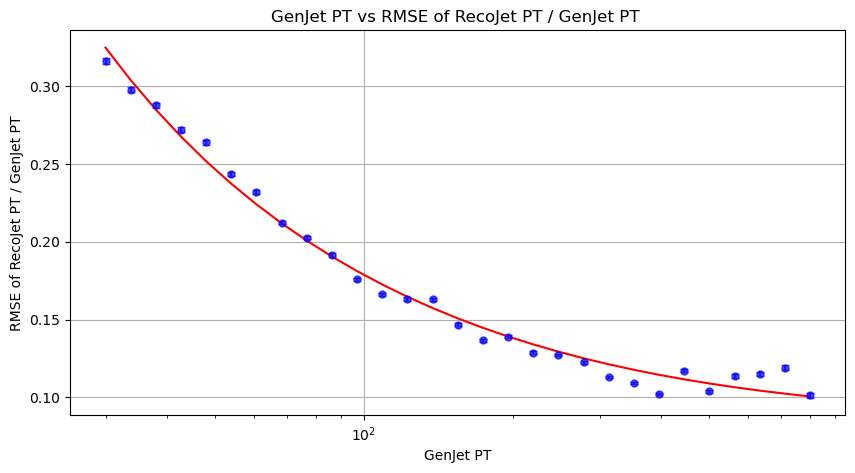

Estimated Parameters:
N: 4.513964754313183
S: -1.5051015851791847
C: 0.0851977755990461


In [174]:
energy_resolution_bars("/data/analysis/rhammad/merged_all_100k_pileUp.root", -100000, 1000000)